# Aprendizagem Automática Avançada
## Project
### Luís Ferreirinha Nº51227
### Christopher Anaya Nº60566

## Imports

In [1]:
import h5py
import clang.cindex
import json
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score
from torch_geometric.data import Dataset

## Data Preprocessing

We start by downloading the Draper dataset from: https://osf.io/d45bw/

This is the dataset we will be analysing in this project, containing over a 1 milion C/C++ function definitions.

In [2]:
train_dataset = h5py.File('../../Dataset/VDISC_train.hdf5')
validation_dataset = h5py.File('../../Dataset/VDISC_validate.hdf5')
test_dataset = h5py.File('../../Dataset/VDISC_test.hdf5')

Now we will convert these datasets to Pandas

In [3]:
def convert_to_pandas(dataset):
    data_frame = {
        'code': dataset['functionSource'],
        'CWE-119': dataset['CWE-119'],
        'CWE-120': dataset['CWE-120'],
        'CWE-469': dataset['CWE-469'],
        'CWE-476': dataset['CWE-476'],
        'CWE-OTHERS': dataset['CWE-other'],
    }

    return pd.DataFrame(data=data_frame)

train_pd = convert_to_pandas(train_dataset)
validation_pd = convert_to_pandas(validation_dataset)
test_pd = convert_to_pandas(test_dataset)

We can now take a look at the dataset

In [4]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,b'visitICmpInst(ICmpInst &I) {\n // We must c...,False,False,False,False,False
1019467,b'path_node_delete_chain(path_node * head)\n{\...,False,False,False,False,False
1019468,b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...,False,False,False,False,False
1019469,"b'Next(const SQObjectPtr &refpos, SQObjectPtr ...",False,False,False,False,False


As we can see this dataset is composed of function definition which are classified according to 5 vulnerability categories.  

For preprocessing and vector embedding processes we will have to join the three datasets. These will later be split before training the models.

In [5]:
dataset_joined = pd.concat([train_pd, validation_pd, test_pd], ignore_index=True)

## Per-Vulnerability Datasets

Since our goal is to train classifiers for each type of vulnerability present here, we will have to split the dataset into 5 ones, one for each vulnerability.

- CWE-120

In [6]:
cols_to_drop = ["CWE-119", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_120_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-119

In [7]:
cols_to_drop = ["CWE-120", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_119_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-469

In [8]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-476", "CWE-OTHERS"]
CWE_469_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-476

In [9]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-OTHERS"]
CWE_476_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-OTHERS

In [10]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-476"]
CWE_OTHERS_df = dataset_joined.drop(cols_to_drop, axis=1)

### Unbalanced classes

The dataset we're using contains a great imbalance in the classes

In [11]:
def plot_classes(dataset, vulnerability):
    shuffled_df = dataset.sample(frac=1,random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability] == False]
    non_normalized_df = pd.concat([vul_df, non_vul_df])
    plt.figure(figsize=(8, 8))
    sns.countplot(x=vulnerability, data=non_normalized_df)
    plt.title('Classes')
    plt.show()

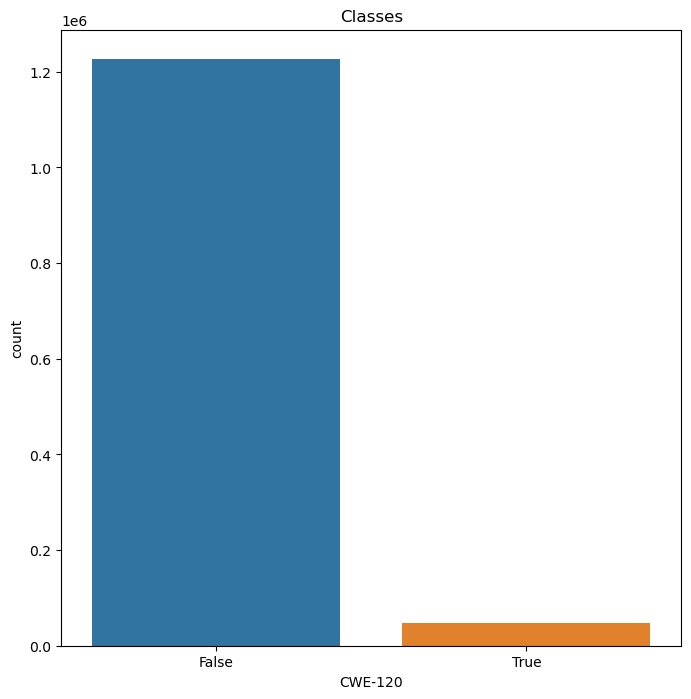

In [12]:
plot_classes(CWE_120_df, 'CWE-120')

We will have to fix this imbalance in the 5 previous datasets we created. This is important, because an imbalanced dataset will hinder the machine learning models and won't allow us to achieve decent classification results.  

To fix this we will apply under-sampling to generate a 50/50 non-vulnerable:vulnerable subset for each vulnerability dataset.

In [13]:
def undersample(dataset, vulnerability_class):
    shuffled_df = dataset.sample(frac=1, random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == 0].sample(n=len(vul_df), random_state=42)
    normalized_df = pd.concat([vul_df, non_vul_df])
    return normalized_df

In [14]:
normalized_CWE_120 = undersample(CWE_120_df, 'CWE-120')
normalized_CWE_119 = undersample(CWE_119_df, 'CWE-119')
normalized_CWE_469 = undersample(CWE_469_df, 'CWE-469')
normalized_CWE_476 = undersample(CWE_476_df, 'CWE-476')
normalized_CWE_OTHERS = undersample(CWE_OTHERS_df, 'CWE-OTHERS')

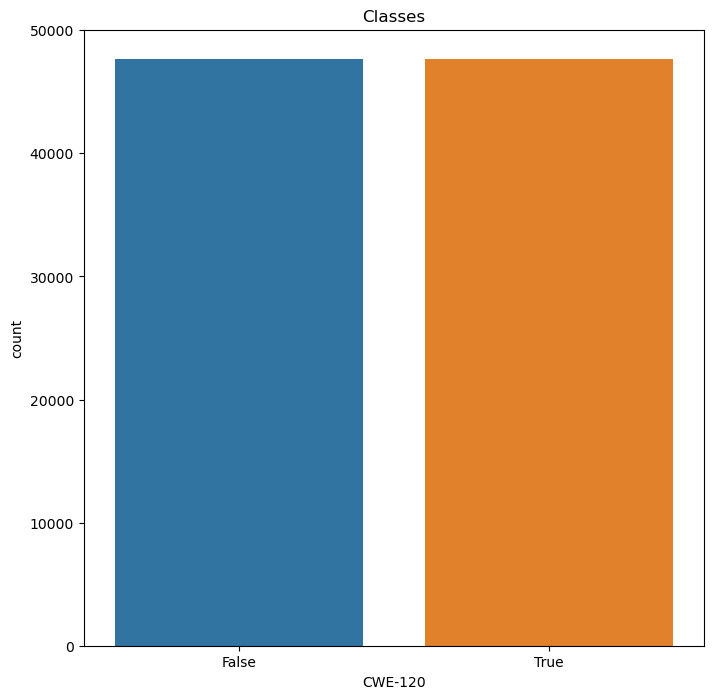

In [15]:
plot_classes(normalized_CWE_120, 'CWE-120')

Now we will prepare the dataset to be processed by clang and to generate the abstract syntax tree

In [16]:
def add_column(row):
    return {"filename": str(row.testCase_ID) + "_vdisc.c"}

def prepare_for_clang(dataset, vulnerability):
    dataset.reset_index(inplace=True)
    dataset['type'] = vulnerability
    dataset.columns = ['testCase_ID', 'code', 'vulnerable', 'type']
    dataset['testCase_ID'] = dataset.index
    filenames = dataset.apply(add_column, axis=1, result_type="expand")
    dataset.insert(1, "filename", filenames, True)

In [17]:
prepare_for_clang(normalized_CWE_119, 'CWE-119')
prepare_for_clang(normalized_CWE_120, 'CWE-120')
prepare_for_clang(normalized_CWE_469, 'CWE-469')
prepare_for_clang(normalized_CWE_476, 'CWE-476')
prepare_for_clang(normalized_CWE_OTHERS, 'CWE-OTHERS')

In [18]:
normalized_CWE_119

,testCase_ID,filename,code,vulnerable,type
0,0,0_vdisc.c,b'CDE_create_path_symlink_dirs() {\n char *p;...,True,CWE-119
1,1,1_vdisc.c,"b'gperror(unsigned int code,\n\t char *mes...",True,CWE-119
2,2,2_vdisc.c,b'test_date_rfc2822__format_rfc2822_positive_o...,True,CWE-119
3,3,3_vdisc.c,"b'toggle_cb (GtkWidget *item, char *pref_name)...",True,CWE-119
4,4,4_vdisc.c,"b'fixgrid34(NCDAPCOMMON* nccomm, CDFnode* grid...",True,CWE-119
...,...,...,...,...,...
48309,48309,48309_vdisc.c,b'fuse_graph_sync (xlator_t *this)\n{\n ...,False,CWE-119
48310,48310,48310_vdisc.c,"b'screen_resize(void)\n{\n gint w, h;\n ...",False,CWE-119
48311,48311,48311_vdisc.c,"b'cmd_cmpfiles (const char *assign_to, char *a...",False,CWE-119
48312,48312,48312_vdisc.c,b'etherType(PPPoEPacket *packet)\n{\n UINT1...,False,CWE-119


We will save the processed datasets as CSVs to facilitate testing and developtment of this project.  

In [47]:
normalized_CWE_119.to_csv("./dataset/preprocessed/vdisc_CWE_119.csv.gz")
normalized_CWE_120.to_csv("./dataset/preprocessed/vdisc_CWE_120.csv.gz")
normalized_CWE_469.to_csv("./dataset/preprocessed/vdisc_CWE_469.csv.gz")
normalized_CWE_476.to_csv("./dataset/preprocessed/vdisc_CWE_476.csv.gz")
normalized_CWE_OTHERS.to_csv("./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz")

## Extratcing the Abstract Syntax Tree

We will a set of functions to extract the AST of the code for each entry in our dataset. The functions we are using we're originally made by the author of the article which we're using as reference for this project, and use the python biddings for the clang compiler to enable the extraction of the AST.

In [20]:
from ast_extraction_graph2vec import *

Now we convert the CSVs to an AST. This takes 1 hour to run! The AST for each function is saved on a graph2vec/vulnerability directory, and these will server as input for graph2vec.

In [21]:
graph_Representaion_process("../../Dataset/vdisc_CWE_119.csv.gz", "./graph2vec/CWE_119/", num_partitions=20)
graph_Representaion_process("../../Dataset/vdisc_CWE_120.csv.gz", "./graph2vec/CWE_120/", num_partitions=20)
graph_Representaion_process("../../Dataset/vdisc_CWE_469.csv.gz", "./graph2vec/CWE_469/", num_partitions=20)
graph_Representaion_process("../../Dataset/vdisc_CWE_476.csv.gz", "./graph2vec/CWE_476/", num_partitions=20)
graph_Representaion_process("../../Dataset/vdisc_CWE_OTHERS.csv.gz", "./graph2vec/CWE_OTHERS/", num_partitions=20)

Preprocess source code files and extracting AST's
Done.
Preprocess source code files and extracting AST's
Done.
Preprocess source code files and extracting AST's
Done.
Preprocess source code files and extracting AST's
Done.
Preprocess source code files and extracting AST's
Done.


'./graph2vec/CWE_OTHERS//graph2vec_input/'

## Creating the Vector Embeddings with Graph2vec

To create the vector embedding of the graph structure (Abstract Syntax Tree) we use the following graph2vec library https://github.com/benedekrozemberczki/graph2vec  

The resulting vector embeddings will be saved in the following directory dataset/embeddings/  

With this new representation of our dataset we can now train regular ML models.

In [ ]:
!python ./graph2vec-lib/src/graph2vec.py --input-path ./graph2vec/CWE_119/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_119.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./graph2vec/CWE_120/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_120.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./graph2vec/CWE_469/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_469.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./graph2vec/CWE_476/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_476.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./graph2vec/CWE_OTHERS/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_OTHERS.csv

## Creating a dataset on Pytorch Geometric to train the Graph Neural Network

In order to train the Graph Neural Network we will have to extract the ASTs and build a dataset on Pytorch Geometric.

In [89]:
from ast_extraction_pytorch import *

class GraphDataset(Dataset):
    def __init__(self, root, path_dataset, transform=None, pre_transform=None):
        self.path_to_data = path_dataset
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    # Dataset class requires the implementation of this method
    @property
    def processed_file_names(self):
        return 'not_implemented.pt'
    
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.path_to_data)
        for index, vuln in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            data = clang_process_pytorch(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

In [92]:
graph_CWE_119 = GraphDataset(root='./dataset/preprocessed/CWE_119', path_dataset='./dataset/preprocessed/vdisc_CWE_119.csv.gz')
graph_CWE_120 = GraphDataset(root='./dataset/preprocessed/CWE_120', path_dataset='./dataset/preprocessed/vdisc_CWE_120.csv.gz')
graph_CWE_469 = GraphDataset(root='./dataset/preprocessed/CWE_469', path_dataset='./dataset/preprocessed/vdisc_CWE_469.csv.gz')
graph_CWE_476 = GraphDataset(root='./dataset/preprocessed/CWE_470', path_dataset='./dataset/preprocessed/vdisc_CWE_476.csv.gz')
graph_CWE_OTHERS = GraphDataset(root='./dataset/preprocessed/CWE_OTHERS', path_dataset='./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz')

Processing...
100%|██████████| 48314/48314 [14:10<00:00, 56.81it/s]
Done!
Processing...
100%|██████████| 95320/95320 [28:21<00:00, 56.01it/s]
Done!
Processing...
100%|██████████| 5250/5250 [01:36<00:00, 54.17it/s]
Done!
Processing...
100%|██████████| 24188/24188 [07:45<00:00, 51.95it/s]
Done!
Processing...
100%|██████████| 70056/70056 [22:38<00:00, 51.56it/s] 
Done!


Since it takes a very long time to process the datasets into graph datasets, we will save them to a file for ease of use.  

We will be saving them in a pickle format, which allows to store python objects in binary files.

In [93]:
import pickle

with open('./dataset/graphs/graph_CWE_119.pkl', 'wb') as outp:
    pickle.dump(graph_CWE_119, outp, pickle.HIGHEST_PROTOCOL)

with open('./dataset/graphs/graph_CWE_120.pkl', 'wb') as outp:
    pickle.dump(graph_CWE_120, outp, pickle.HIGHEST_PROTOCOL)

with open('./dataset/graphs/graph_CWE_469.pkl', 'wb') as outp:
    pickle.dump(graph_CWE_469, outp, pickle.HIGHEST_PROTOCOL)

with open('./dataset/graphs/graph_CWE_470.pkl', 'wb') as outp:
    # Typo in previous dataset definiton, but since it takes over an hour to redo it
    # I will just leave the typo here 
    pickle.dump(graph_CWE_476, outp, pickle.HIGHEST_PROTOCOL)

with open('./dataset/graphs/graph_CWE_OTHERS.pkl', 'wb') as outp:
    pickle.dump(graph_CWE_OTHERS, outp, pickle.HIGHEST_PROTOCOL)

If you want to work on this you must first transfer the pre-processed dataset